In [1]:
# Head here "https://www.kaggle.com/sayantandas30011998/zanzibar-openai-building-footprint-mapping?select=znz-segment-z19" get the data by doing some network reading stuff!
! wget "https://storage.googleapis.com/kaggle-data-sets/414435%2F792737%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1595937451&Signature=L6Uteke6e%2F2W%2FecHV%2FT1zZsaCDtsupkl45WG50Oo0x62So7Dqkhakg967o7QrlLywMMUqe%2FM04LiUs6Ls%2FnKkBXe%2FYz9UIyd%2FfH0JaKLMw7kMmXy9nosgCGl0zxhQL0O8R8IUdPxA%2BpqODtgGH3R80eUL%2BWjOWVoTP7dVHZyVmSwIEBCMhkXyqzZOiY0DHjVX8iFLliTjZsoKA%2FaieRysaTd6qPHZpbSMnTqqIEZx1%2BRXBmR%2FVtx%2BM7W3KyULgxsehsWPEEQ2fvXVePV0%2F%2BxUL4I3J2xbjz0iGDRLODxgKNWq2YhnG3p1cwcyuPjI1kn%2Bk9rNl0X0RLJpLqKh0CITw%3D%3D" -O znz-classify.zip

--2020-07-25 12:41:29--  https://storage.googleapis.com/kaggle-data-sets/414435%2F792737%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1595937451&Signature=L6Uteke6e%2F2W%2FecHV%2FT1zZsaCDtsupkl45WG50Oo0x62So7Dqkhakg967o7QrlLywMMUqe%2FM04LiUs6Ls%2FnKkBXe%2FYz9UIyd%2FfH0JaKLMw7kMmXy9nosgCGl0zxhQL0O8R8IUdPxA%2BpqODtgGH3R80eUL%2BWjOWVoTP7dVHZyVmSwIEBCMhkXyqzZOiY0DHjVX8iFLliTjZsoKA%2FaieRysaTd6qPHZpbSMnTqqIEZx1%2BRXBmR%2FVtx%2BM7W3KyULgxsehsWPEEQ2fvXVePV0%2F%2BxUL4I3J2xbjz0iGDRLODxgKNWq2YhnG3p1cwcyuPjI1kn%2Bk9rNl0X0RLJpLqKh0CITw%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.120.128, 64.233.167.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494780259 (472M) [application/zip]
Saving to: ‘znz-classify.zip’

znz-classify.zip    100%[===================>] 471.86M  30.4MB/s    in 20s    

In [2]:
! unzip -qq znz-classify.zip

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision 
from tensorflow.keras import backend as K


In [5]:
PATH = "znz-segment-z19/znz-train-z19-all-buffered/"

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

IMG_SIZE = 256
EPOCHS = 150
BATCH = 32
LR = 1e-4

In [7]:
def load_data(path, split=0.1):
    images_list = sorted(glob(os.path.join(path, "images-512/*")))
    masks_list = sorted(glob(os.path.join(path, "masks-512/*")))

    tot_size = len(images_list)
    val_size = int(split * tot_size)
    test_size = int(split * tot_size)

    x_train, x_val = train_test_split(images_list, test_size=val_size, random_state=42)
    y_train, y_val = train_test_split(masks_list, test_size=val_size, random_state=42)

    x_train, x_test = train_test_split(x_train, test_size=test_size, random_state=42)
    y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [8]:
def read_img(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_COLOR)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    return tmp

def read_mask(path):
    path = path.decode()
    tmp = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    tmp = cv2.resize(tmp, (IMG_SIZE, IMG_SIZE))
    tmp = tmp/255.0
    tmp = np.expand_dims(tmp, axis=-1)
    return tmp

In [9]:
def tf_parse(a, b):
    def _parse(a, b):
        a = read_img(a)
        b = read_mask(b)
        return a, b

    a, b = tf.numpy_function(_parse, [a, b], [tf.float64, tf.float64])
    a.set_shape([IMG_SIZE, IMG_SIZE, 3])
    b.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return a, b

def tf_dataset(a, b, batch=32):
    data = tf.data.Dataset.from_tensor_slices((a, b))
    data = data.map(tf_parse)
    data = data.batch(batch)
    data = data.repeat()
    return data

In [10]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data(PATH)

print("Training data: ", len(x_train))
print("Validation data: ", len(x_val))
print("Testing data: ", len(x_test))


Training data:  2153
Validation data:  269
Testing data:  269


In [11]:
def read_and_rgb(a):
    a = cv2.imread(a)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return a

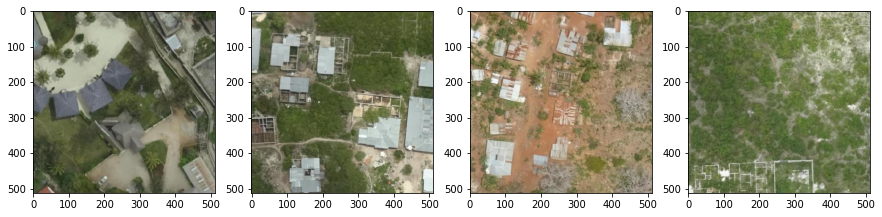

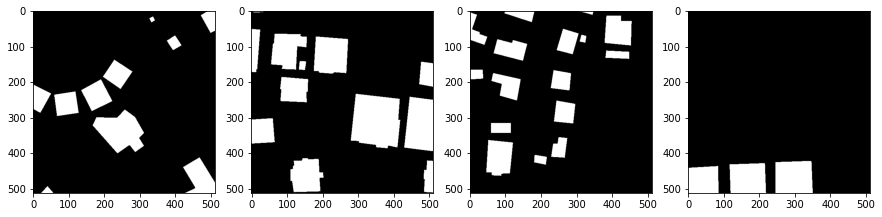

In [12]:
fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(x_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(x_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(x_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(x_train[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
x = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(y_train[0]))

x = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(y_train[1]))
imgplot.set_clim(0.0, 0.7)

x = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(y_train[2]))
imgplot.set_clim(0.0, 1.4)

x = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(y_train[3]))
imgplot.set_clim(0.0, 1.4)

In [13]:
def model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.50)
    skip_connection_list = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    fil = [48, 64, 96, 128]
    xt = encoder_output
    for i in range(1, len(skip_connection_list)+1, 1):
        xt_skip = encoder.get_layer(skip_connection_list[-i]).output
        xt = UpSampling2D((2, 2))(xt)
        xt = Concatenate()([xt, xt_skip])
        
        xt = Conv2D(fil[-i], (3, 3), padding="same")(xt)
        xt = BatchNormalization()(xt)
        xt = Activation("relu")(xt)
        
        xt = Conv2D(fil[-i], (3, 3), padding="same")(xt)
        xt = BatchNormalization()(xt)
        xt = Activation("relu")(xt)
        
    xt = Conv2D(1, (1, 1), padding="same")(xt)
    xt = Activation("sigmoid")(xt)
    
    model = Model(inputs, xt)
    return model

In [14]:
model = model()
model.summary()

3203072/3201480 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
_______________________________

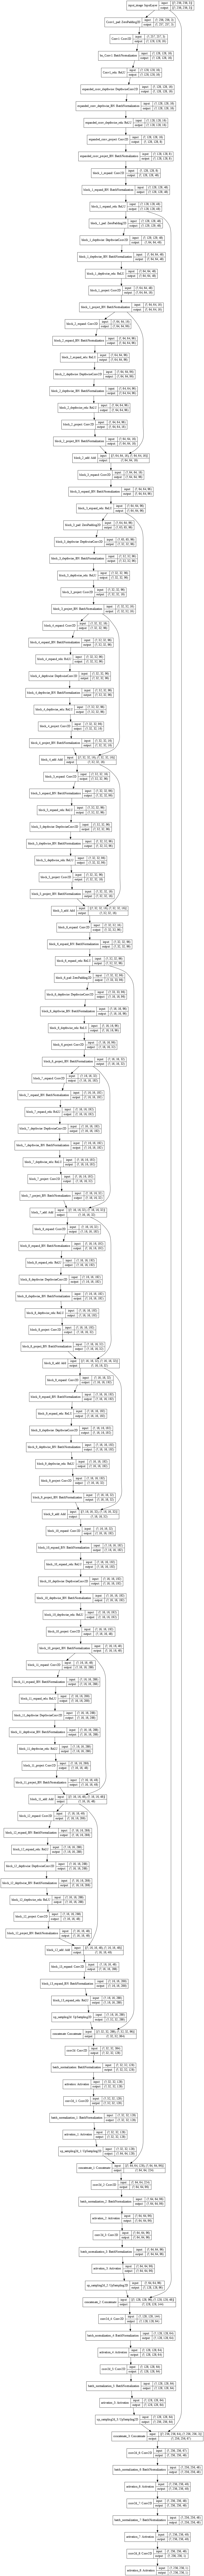

In [15]:
from tensorflow.keras.utils import  plot_model as pm  #plotting the model structure
pm(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [16]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [17]:
train_data = tf_dataset(x_train, y_train, batch=BATCH)
valid_data = tf_dataset(x_val, y_val, batch=BATCH)

In [18]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [19]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [20]:
train_steps = len(x_train)//BATCH
valid_steps = len(x_val)//BATCH

if len(x_train) % BATCH != 0:
    train_steps += 1
if len(x_val) % BATCH != 0:
    valid_steps += 1

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/150
53/68 [======================>.......] - ETA: 18s - loss: 0.6220 - dice_coef: 0.3780 - recall: 0.8244 - precision: 0.4577

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['acc']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in history.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(history.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()
plt.savefig('acc_BuildingDetectionUNet.png')

In [ ]:
model.save_weights("UNetW_150e.h5")

model.save("Unet_with_weight_150e.h5")


In [ ]:
# Run this module only while loading the pre-trained model.
model = load_model('Unet_with_weight_150e.h5',custom_objects={'dice_loss': dice_loss,'dice_coef':dice_coef})
model.summary()


In [ ]:
test_data = tf_dataset(x_test, y_test, batch=BATCH)

test_steps = (len(x_test)//BATCH)
if len(x_test) % BATCH != 0:
    test_steps += 1

model.evaluate(test_data, steps=test_steps)



In [ ]:
def read_img(path):
    xt = cv2.imread(path, cv2.IMREAD_COLOR)
    xt = cv2.cvtColor(xt, cv2.COLOR_BGR2RGB)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = xt/255.0
    return xt

def read_mask(path):
    xt = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    xt = cv2.resize(xt, (IMG_SIZE, IMG_SIZE))
    xt = np.expand_dims(xt, axis=-1)
    xt = xt/255.0
    return xt

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
for i, (a, b) in enumerate(zip(x_test[10:20], y_test[10:20])):
    a = read_img(a)
    b = read_mask(b)
    y_pred = model.predict(np.expand_dims(a, axis=0))[0] > 0.5
    h, w, _ = a.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        a, white_line,
        mask_parse(b), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    x = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
